In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../data/FULL_Shot_Data.csv")
df.head()

,Unnamed: 0,id,minute,result,X,Y,xG,player,h_a,player_id,...,season,shotType,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction
0,0,14642,83,BlockedShot,0.795,0.321,0.047510,Harry Kane,a,647,...,2014,RightFoot,4754,West Ham,Tottenham,0,1,2014-08-16 15:00:00,Andros Townsend,Pass
1,1,15400,81,OwnGoal,0.029,0.582,0.000000,Harry Kane,a,647,...,2014,OtherBodyPart,4724,Sunderland,Tottenham,2,2,2014-09-13 15:00:00,NaN,Foul
2,2,16333,68,SavedShot,0.906,0.469,0.435830,Harry Kane,h,647,...,2014,LeftFoot,4715,Tottenham,Newcastle United,1,2,2014-10-26 13:30:00,Danny Rose,Pass
3,3,16901,58,SavedShot,0.917,0.463,0.085788,Harry Kane,a,647,...,2014,Head,4657,Aston Villa,Tottenham,1,2,2014-11-02 16:00:00,Erik Lamela,Cross
4,4,16909,89,Goal,0.761,0.415,0.067692,Harry Kane,a,647,...,2014,RightFoot,4657,Aston Villa,Tottenham,1,2,2014-11-02 16:00:00,NaN,Standard


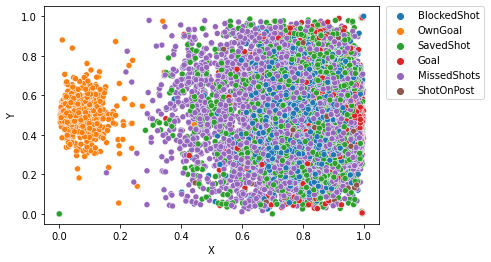

In [3]:
sns.scatterplot(data=df, x='X', y='Y', hue='result')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [4]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

In [5]:
# attack_df = df[(df['result'] != 'OwnGoal') & (df['situation'] == 'OpenPlay')].copy()
# attack_df = df[(df['result'] != 'OwnGoal')].copy()
attack_df = df[(df['result'] != 'OwnGoal') & (df['situation'] == 'OpenPlay') & (df['shotType'] == 'RightFoot')].copy()

In [6]:
attack_df['outcome'] = (attack_df['result'] == 'Goal').astype(int)

In [7]:
attack_df.columns

Index(['Unnamed: 0', 'id', 'minute', 'result', 'X', 'Y', 'xG', 'player', 'h_a',
       'player_id', 'situation', 'season', 'shotType', 'match_id', 'h_team',
       'a_team', 'h_goals', 'a_goals', 'date', 'player_assisted', 'lastAction',
       'outcome'],
      dtype='object')

In [8]:
input_data = attack_df[['X', 'Y', 'situation', 'shotType', 'outcome']].copy()
input_data_encoded = pd.concat([
        input_data[['X', 'Y']],
        pd.get_dummies(input_data['situation']),
        pd.get_dummies(input_data['shotType'])
        ], axis=1)
output_data = input_data['outcome']
input_data_encoded.head()

,X,Y,OpenPlay,RightFoot
0,0.795,0.321,1,1
9,0.775,0.793,1,1
15,0.795,0.330,1,1
16,0.786,0.511,1,1
21,0.847,0.687,1,1


In [9]:
X_train, X_test, y_train, y_test = train_test_split(input_data_encoded.values, output_data.values, random_state=0, test_size=0.3)

In [21]:
reg = XGBClassifier(scale_pos_weight=1, use_label_encoder=False)
reg.fit(X_train, y_train)

[17:05:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [22]:
y_pred = reg.predict(X_test)

In [23]:
y_pred, y_test

(array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]))

In [24]:
print("Test", accuracy_score(y_pred, y_test), "Train", accuracy_score(reg.predict(X_train), y_train), "ROC AUC Score", roc_auc_score(y_test, y_pred), "PR AUC Score", average_precision_score(y_test, y_pred))
       

Test 0.9041575118923185 Train 0.9058180355445038 ROC AUC Score 0.5436806551555948 PR AUC Score 0.14750520745578338


In [25]:
p_vals = reg.predict_proba(input_data_encoded.values)[:,1]
p_vals

array([0.0202553 , 0.01098916, 0.02529554, ..., 0.02305046, 0.02651807,
       0.02572898], dtype=float32)

In [26]:
pred = list(p_vals)
attack_df['prediction'] = pred

In [27]:
attack_df[['xG', 'prediction', 'outcome']]

,xG,prediction,outcome
0,0.047510,0.020255,0
9,0.015956,0.010989,0
15,0.023591,0.025296,0
16,0.040104,0.065638,0
21,0.035595,0.032990,0
...,...,...,...
384450,0.016519,0.033567,0
384451,0.009004,0.015298,0
384455,0.028553,0.023050,0
384458,0.014314,0.026518,0


In [28]:
attack_df.iloc[0]

Unnamed: 0                           0
id                               14642
minute                              83
result                     BlockedShot
X                                0.795
Y                                0.321
xG                             0.04751
player                      Harry Kane
h_a                                  a
player_id                          647
situation                     OpenPlay
season                            2014
shotType                     RightFoot
match_id                          4754
h_team                        West Ham
a_team                       Tottenham
h_goals                              0
a_goals                              1
date               2014-08-16 15:00:00
player_assisted        Andros Townsend
lastAction                        Pass
outcome                              0
prediction                    0.020255
Name: 0, dtype: object

In [29]:
from sklearn.metrics import plot_confusion_matrix

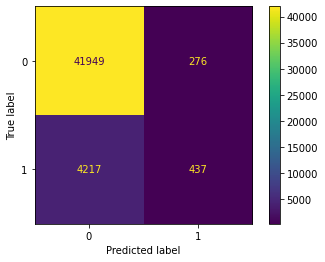

In [30]:
plot_confusion_matrix(reg, X_test, y_test)